# Machine learning on dye molecule data obtained by xTB

## Import the data into a dataframe

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('./sample-data-dyes.txt', sep='\t')
data = data[data.Solvent == 'thf'] # let's only look at results where we used THF as a solvent
data

FileNotFoundError: File b'./sample-data-dyes.txt' does not exist

## Use RDKit to produce molecular 'fingerprints'

In [5]:
import rdkit, rdkit.Chem, rdkit.Chem.AllChem as rdkit
from rdkit.Chem.EState import Fingerprinter

# I make helper functions to do the fingerprinting so that I may use the df.apply method of pandas
def generate_morgan_fingerprints(mol):
    fp = rdkit.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) # look up morgan/ECFP finferprints to understand these parameters. they are important!
    return np.array(fp)
    
def generate_estate_fingerprints(mol):
    return Fingerprinter.FingerprintMol(mol)[1]
   
# we need rdkit mol objects to do fingerprinting, so let's make them first (again using df.apply)
data['rdkit_mol'] = data['Oligomer SMILES'].apply(rdkit.MolFromSmiles)
data['Morgan_FP'] = data['rdkit_mol'].apply(generate_morgan_fingerprints)
data['Estate_FP'] = data['rdkit_mol'].apply(generate_estate_fingerprints)

# looking at the dataframe again we can see the added columns
data

,Solvent ID,Core ID,Side ID,VIP,VEA,EE,Oscillator_S,core SMILES,side SMILES,Oligomer SMILES,Solvent,rdkit_mol,Morgan_FP,Estate_FP
0,0,0,7,5.6877,2.9862,2.648,0.7351,O=c1[nH]c(Br)c2c(=O)[nH]c(Br)c12,Nc1ccc(Br)cc1Br,[H]C1=C([H])C([H])=C(N([H])[H])C(C2=C3C(=O)N([...,thf,<rdkit.Chem.rdchem.Mol object at 0x7f5f2ee61760>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,0,6,5.6879,2.9868,2.648,0.7364,O=c1[nH]c(Br)c2c(=O)[nH]c(Br)c12,Nc1cccc(Br)c1Br,[H]C1=C([H])C([H])=C(N([H])[H])C(C2=C3C(=O)N([...,thf,<rdkit.Chem.rdchem.Mol object at 0x7f5f1f823da0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,0,3,5.7644,3.2451,2.708,0.7385,O=c1[nH]c(Br)c2c(=O)[nH]c(Br)c12,CN(C)c1ccc(Br)c(Br)c1,[H]C1=C([H])C(C2=C3C(=O)N([H])C(C4=C([H])C(N(C...,thf,<rdkit.Chem.rdchem.Mol object at 0x7f5f1f823c60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.8079480557655..."
3,0,0,1,5.9179,3.2587,2.668,0.8412,O=c1[nH]c(Br)c2c(=O)[nH]c(Br)c12,CN(C)c1ccc(Br)cc1Br,[H]C1=C([H])C([H])=C(N(C([H])([H])[H])C([H])([...,thf,<rdkit.Chem.rdchem.Mol object at 0x7f5f1f823e90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.7423065213739..."
4,0,0,2,5.9207,3.2622,2.668,0.8424,O=c1[nH]c(Br)c2c(=O)[nH]c(Br)c12,CN(C)c1cc(Br)ccc1Br,[H]C1=C([H])C([H])=C(N(C([H])([H])[H])C([H])([...,thf,<rdkit.Chem.rdchem.Mol object at 0x7f5f1f823ee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.7423065213739..."


## Prepare the data for learning

In [6]:
# We need to define what our input and outputs are (i.e. our descriptors and our target values).
# We also need to split our data into 'training' (what we will use to make a model) and 'testing'
# (what we will need to evaluate the model).

descriptors = ['Morgan_FP', 'Estate_FP'] # a list of the different fingerprints we made above

X = list(data.Morgan_FP)
y = np.column_stack((data.VIP.values, data.VEA.values, data.EE.values)) # we make a 1x3 array for y since we want to simultaneously predict IP, EA and optical gap

# now let's split the data into our training and testing subgroups
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # we split X & y (70 % train, 30% test)

## Learning : a few different techniques

In [7]:
''' 
We will try:
    1. Multi Linear regression 
    2. Random forest
'''

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict(X_test)

# for the RF model, we could do 'hyperparameter tuning', but let's just leave everything as default
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)

## Plot the results

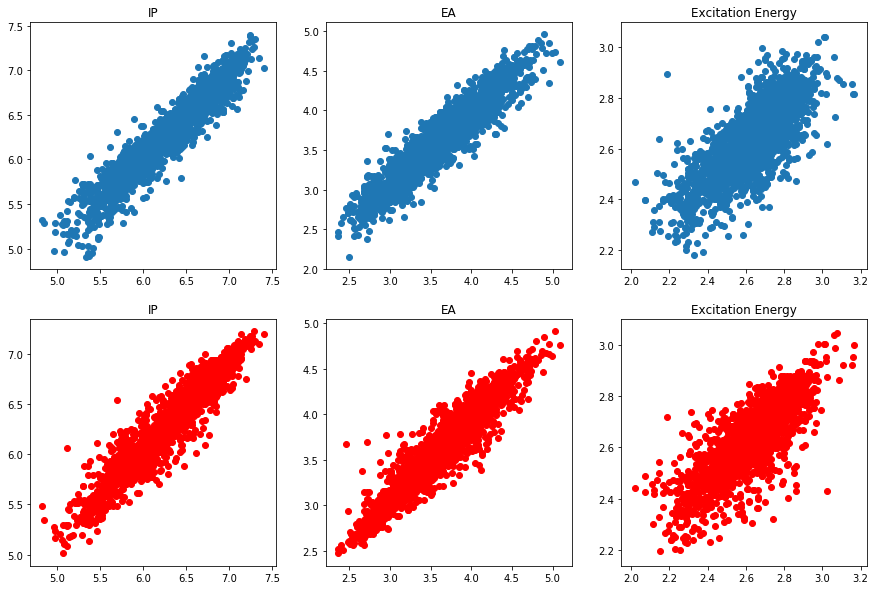

In [8]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1.set_title('IP')
ax2.set_title('EA')
ax3.set_title('Excitation Energy')
ax1.scatter(y_test[:,0], LR_pred[:,0])
ax2.scatter(y_test[:,1], LR_pred[:,1])
ax3.scatter(y_test[:,2], LR_pred[:,2])

ax4.set_title('IP')
ax5.set_title('EA')
ax6.set_title('Excitation Energy')
ax4.scatter(y_test[:,0], RF_pred[:,0], c='r')
ax5.scatter(y_test[:,1], RF_pred[:,1], c='r')
ax6.scatter(y_test[:,2], RF_pred[:,2], c='r')

plt.show()

## Plot the results better

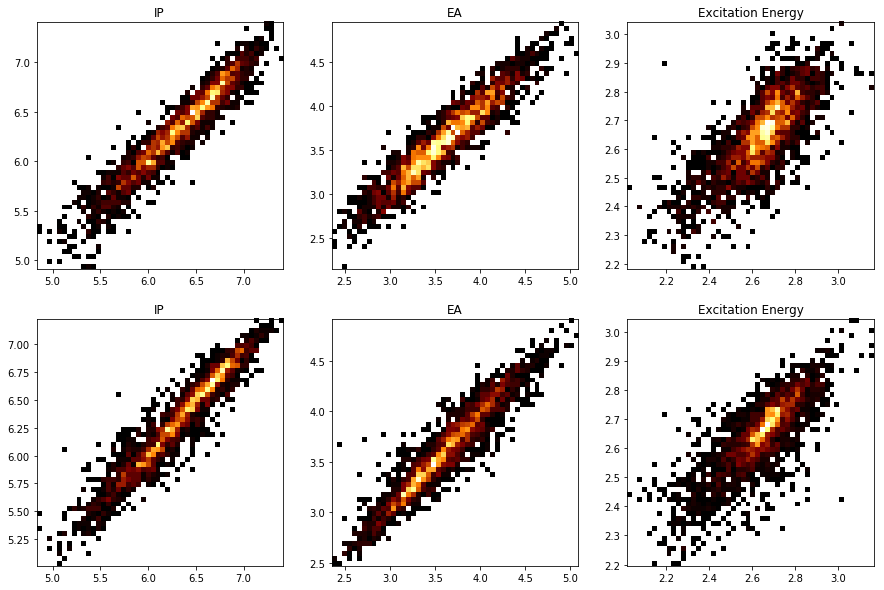

In [10]:
# above we know the space spanned by our scatter plots, but we have no idea how many points are 
# in a particular region of the graph. To remedy this, we can use 2D histograms...

import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1.set_title('IP')
ax2.set_title('EA')
ax3.set_title('Excitation Energy')
ax1.hist2d(y_test[:,0], LR_pred[:,0], bins=50, cmap='afmhot', cmin=1)
ax2.hist2d(y_test[:,1], LR_pred[:,1], bins=50, cmap='afmhot', cmin=1)
ax3.hist2d(y_test[:,2], LR_pred[:,2], bins=50, cmap='afmhot', cmin=1)

ax4.set_title('IP')
ax5.set_title('EA')
ax6.set_title('Excitation Energy')
ax4.hist2d(y_test[:,0], RF_pred[:,0], bins=50, cmap='afmhot', cmin=1)
ax5.hist2d(y_test[:,1], RF_pred[:,1], bins=50, cmap='afmhot', cmin=1)
ax6.hist2d(y_test[:,2], RF_pred[:,2], bins=50, cmap='afmhot', cmin=1)

plt.show()

## Calculate some statistics to evaluate the model(s)

In [11]:
total_mae = np.mean(np.abs(RF_pred - y_test))
ip_mae = np.mean(np.abs(RF_pred[:,0] - y_test[:,0]))
ea_mae = np.mean(np.abs(RF_pred[:,1] - y_test[:,1]))
gap_mae = np.mean(np.abs(RF_pred[:,2] - y_test[:,2]))

print('Total MAE (eV) =', total_mae)
print('IP MAE (eV) =', ip_mae)
print('EA MAE (eV) =', ea_mae)
print('Excitation Energy MAE (eV) =', gap_mae)

Total MAE (eV) = 0.08941015316137041
IP MAE (eV) = 0.0937576882360725
EA MAE (eV) = 0.10784924419648761
Excitation Energy MAE (eV) = 0.06662352705155107
